<a href="https://colab.research.google.com/github/treetops81/Twitter-COP26/blob/main/Twitter_API_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explatory analysis - COP26 Tweets during event
I applied for a twitter API license and pulled tweets duing the COP26 event relating to COP26 and climate change, to investigate the publics sentiment around the event and what they were most interested in.

### What would I like to find out:


1.   What are the key themes that people are talking about?
2.   What is the overall public sentiment of the event? Can I compare this to twitter / social media benchmark?
3. Does sentiment vary over the different themes of discussion?
4. Can we see any significant climate denial coming through?

5. Named Entity Recognition - Does this actually help?

In [77]:
%%capture
# Download required packages that are not available already on google colab.
!pip install demoji
!pip install spacytextblob
!python -m spacy download en_core_web_sm 
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install vaderSentiment

Model v1 contains climate change
Model v2 removes climate change by making it a stop word

## Import required libraries
If required, run the above code upon opening so that google colab has the required libraries 

In [78]:
# Import required libraries

# Twitter specific
import tweepy

# General analysis packages
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle

# Language Packages
import demoji  
from string import punctuation
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from textblob import TextBlob
from gsdmm import MovieGroupProcess
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Preload the spacy model
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob') # Allows us to use the textblob sentiment analysis tools with spacy
# Add any other required stop words
nlp.Defaults.stop_words.add("cop26")

# Redirect the current python folder to where the Twitter files are located
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Twitter/') # If you map this to where this notebook is saved then gsdmm shoud install in the same location

## 0. Load and clean data

In [79]:
# # Make sure that Google Drive is mounted before trying to call the below
# # Loads my private twitter keys
# %run "Twitter Info.ipynb"

In [80]:
# # Set up twitter API authentication 
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)
# api = tweepy.API(auth)

In [81]:
# Load the combined and partially cleaned dataset
tweet_df = pd.read_csv('tweet_df_initial_clean.csv', encoding = 'utf-8', index_col = 0)

# My pull out emojis from the tweet data (descriptions)
tweet_df['emojis'] = tweet_df['tweets'].apply(lambda x: list(demoji.findall(x).values()))

# Flag tweets containing links - these usually refer to another tweet or picture that doesn't provide us any information.
def find_link(text):
    if 'https' in text:
        return True
    else: 
        return False

tweet_df['link_check'] = tweet_df['tweets'].apply(lambda x: find_link(x))

In [82]:
# Finds mentions in tweets and creates a new column. 
# Regex expression checks that no @ or letters (or numbers) proceed an @ symbol and then capture to 25 a-Z 0-9 characters afterwards.
tweet_df['mentions'] = tweet_df.tweets.str.findall(r'(?<![@\w])@(\w{1,25})')

In [83]:
# Replace emojis with their description in words in a string using demoji function replace_with_desc
def replace_emoji(text):
    text = replace_with_desc(text, "")
    return text

In [84]:
# Remove Emojis from text strings - Useful website for finding unicodes of emojis not currently included: https://unicode.org/emoji/charts/full-emoji-list.html#231b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002318-\U0001F566"  # clocks
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [85]:
# Remove links from text
def remove_links(text):
    url_pattern = re.compile(r"http\S+")
    return re.sub(url_pattern, '', text)

In [86]:
# Remove dates (run before remove punctuation) - Very Basic Version
def remove_dates(text):
    text = re.sub('\d+(\/\d+)+', '', text) # Removes digits seperated by forward slashes 
    return text

In [87]:
# Omit full stops and @ symbols from the punctuation variable (may be useful for other types of analysis)
punctuation_edit = punctuation[:13] + punctuation[14:21] + punctuation[22:]
punctuation_edit

'!"#$%&\'()*+,-/:;<=>?[\\]^_`{|}~'

In [88]:
# Remove all punctuation except for omissions in punctution_edit / punctutation
def remove_punc(text):
    text = ' '.join(text.split())
    text = re.sub('/', ' ', text)
    text = (text.encode('ascii', 'ignore')).decode()
    text = re.sub(' +', ' ', text)
    text = re.sub(r' +\. +', '. ', text)
    text = text.strip()
    text = ''.join([char for char in text if char not in punctuation])
    #text = ''.join([char for char in text if char not in punctuation_edit]) # Omits '.' & '@'
    return text

In [89]:
# Remove mentions from text
def remove_mention(text):
    return re.sub('@\w+', '', text)

In [90]:
# Clean text, calling all the sub-cleaning functions
def clean_text(text):
    #text = text.lower() - Preprocessing late via SpaCy does the same thing and this makes text more readible until then.
    #text = replace_emoji(text)
    text = re.sub('&amp;', 'and', text) # Replace &amp: with '&' - encoding error
    text = remove_emoji(text)
    text = remove_links(text)
    text = remove_dates(text)
    text = remove_mention(text)
    text = remove_punc(text) 
    return text

In [91]:
# Create a new column based of the cleaning function
tweet_df['clean_tweet'] = tweet_df['tweets'].apply(lambda x: clean_text(x))
tweet_df.head(3)

,tweets,likes,time,verified,user,hashtags,emojis,link_check,mentions,clean_tweet
0,#COP26 has been named the must excluding COP e...,53660,2021-11-04 16:20:40,True,Greta Thunberg,"[{'text': 'COP26', 'indices': [0, 6]}]",[],False,[],COP26 has been named the must excluding COP ev...
1,Indonesia reversed a #COP26 pledge to end defo...,5618,2021-11-04 14:31:00,True,AJ+,"[{'text': 'COP26', 'indices': [21, 27]}]",[],True,[],Indonesia reversed a COP26 pledge to end defor...
2,Sir David Attenborough full speech to World Le...,5227,2021-11-04 10:10:55,True,Chris Packham,"[{'text': 'COP26', 'indices': [69, 75]}, {'tex...",[],True,[],Sir David Attenborough full speech to World Le...


In [92]:
# Remove 'to_remove items' from a target list - used to clean the hashtags column read directly from Twitter API
# Input: list (target) & str/list containing items to remove, Output: list (target minus the defined items)
def remove_all(target_list, to_remove):
    if isinstance(to_remove, str): # Remove from a string
        for item in target_list:
            if item == to_remove:
                target_list.remove(to_remove) 
    
    elif isinstance(to_remove, list): # Remove from a list
        for rem_item in to_remove:
            for item in target_list:
                if item == rem_item:
                    target_list.remove(rem_item) 

    return target_list

In [93]:
# Take in the hashtags format from twitter, extract the hashtags by finding the text within the entry and remove the words 'text' and 'indices'
def fix_hashtags(hashtag_list):
    hashtag_string = re.findall(r"'(.*?)'", hashtag_list)
    hashtag_list_out = remove_all(hashtag_string, ['text', 'indices'])
    return hashtag_list_out

In [94]:
# Apply fix_hashtags
tweet_df['hashtags_clean'] = tweet_df['hashtags'].apply(lambda x: fix_hashtags(x))

# Drop old hashtag column and reorder columns
tweet_df.drop(columns = ['hashtags'])
tweet_df = tweet_df.reindex(columns = ['clean_tweet', 'emojis', 'hashtags_clean', 'mentions', 'likes', 'link_check', 'time', 'verified', 'user', 'tweets'])
tweet_df.to_csv('tweet_df.csv', encoding = 'utf-8')

## 0.5 Quick analysis of hashtags, emojis and mentions within our dataset

In [95]:
# Look at the number of duplicate tweets
print(tweet_df.shape[0])
print(tweet_df.clean_tweet.value_counts()[tweet_df.clean_tweet.value_counts() > 1].sum())

40708
4031


In [96]:
# Drop duplicates, sorting by tweet and then likes
def drop_dupes(df):
    sorted_df = df.sort_values(by=['clean_tweet', 'likes'])
    df_trimmed = df.drop_duplicates(subset=['clean_tweet'])
    df_trimmed = df_trimmed.sort_index()
    return df_trimmed.reset_index(drop=True)

In [97]:
# Print df shape
print(tweet_df.shape)

# Drop duplicates and reprint shape
tweet_df = drop_dupes(tweet_df)
print(tweet_df.shape)

(40708, 10)
(37822, 10)


In [98]:
# Look at user counts and tweets per user to check that no one user is a major component of our dataset
print('Total number of users in dataset:', len(tweet_df.user.unique()))
tweet_df.user.value_counts()

Total number of users in dataset: 27616


RSMacKinnon (he/him)    54
UNFCCC                  50
Top Banana Antiques     47
Greta Thunberg News     34
Earth Observer          29
                        ..
Nicole G                 1
Bell House               1
PNW Collage              1
Shilpy Sharma            1
Jainish Rathod           1
Name: user, Length: 27616, dtype: int64

In [99]:
# Create some variables describing the hashtags found in our tweets
# None of these look out of place
hashtag_list = tweet_df.hashtags_clean.to_list()
all_hashtags = [hash.lower() for hashtag in hashtag_list for hash in hashtag] # List of all hashtags (with repetition)
unique_hashes = list(set(all_hashtags)) # List of all hashtags (without repitition)
hash_counts = dict(zip(unique_hashes, [all_hashtags.count(hash) for hash in unique_hashes])) # Dictionary of hashtag counts
hash_counter = Counter(hash_counts)
common_hashes = hash_counter.most_common(20)
for i in common_hashes:
    print(i[0], ':', i[1])

cop26 : 17983
climatechange : 1749
climateaction : 1221
climatecrisis : 900
climate : 872
cop26glasgow : 758
climateemergency : 647
togetherforourplanet : 636
netzero : 463
climatejustice : 392
glasgow : 370
sustainability : 320
climateactionnow : 288
environment : 240
uprootthesystem : 236
auspol : 220
globalwarming : 215
klimalaya : 202
worldclimatemarch : 185
endclimateimperialism : 175


In [100]:
# Create some variables describing the mentions found in our tweets
# None of these look out of place - note that Veritatem2021 is an anti climate change account
mention_list = tweet_df.mentions.to_list()
all_mention = [mention.lower() for mention_sub_list in mention_list for mention in mention_sub_list] # List of all mentions (with repetition)
unique_mention = list(set(all_mention)) # List of all mentions (without repitition)
mention_counts = dict(zip(unique_mention, [all_mention.count(mention) for mention in unique_mention])) # Dictionary of mention counts
mention_counter = Counter(mention_counts)
common_mention = mention_counter.most_common(20)
for i in common_mention:
    print(i[0], ':', i[1])

cop26 : 3583
borisjohnson : 1097
gretathunberg : 278
unfccc : 268
aloksharma_rdg : 264
youtube : 186
un : 167
nicolasturgeon : 163
cop26_coalition : 153
potus : 152
unep : 123
skynews : 122
breezyscroll : 109
bbcnews : 102
scottmorrisonmp : 99
geraldkutney : 98
ejwwest : 93
veritatem2021 : 87
gbnews : 86
georgemonbiot : 85


In [101]:
# Create some variables describing the emojis found in our tweets
# A lot of the emojis seem to be a reference the tweet (i.e index finger pointing right or left) so we may be want to remove them and only add in sentiment where its positive or negative, i.e. smiley faces
emoji_list = tweet_df.emojis.to_list()
all_emojis = [emojis.lower() for emoji_sub_list in emoji_list for emojis in emoji_sub_list] # List of all emojis (with repetition)
unique_emoji = list(set(all_emojis)) # List of all emojis (without repitition)
emoji_counts = dict(zip(unique_emoji, [all_emojis.count(emojis) for emojis in unique_emoji])) # Dictionary of emojid counts
emoji_counter = Counter(emoji_counts)
common_emojis = emoji_counter.most_common(20)
for i in common_emojis:
    print(i[0], ':', i[1])

globe showing europe-africa : 541
backhand index pointing down : 501
backhand index pointing right : 378
globe showing americas : 297
right arrow : 245
green heart : 205
down arrow : 164
thinking face : 152
globe showing asia-australia : 150
face with tears of joy : 149
seedling : 143
deciduous tree : 138
rolling on the floor laughing : 124
clapping hands : 122
loudspeaker : 117
face with rolling eyes : 99
flag: united kingdom : 97
flag: scotland : 89
thumbs up : 88
fire : 85


## 1. Topic Modelling - GDSMM
An GDSMM is model which only assumes one topic per document (which is much more likely for short from documents such as Tweets compared to the multi topic assumption required for LDA.
* GitHub Repo: https://github.com/rwalk/gsdmm
* Full paper here: https://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf

In [102]:
# Apply spacy preprocessing to the documents in our dataset
docs = list(nlp.pipe(tweet_df.clean_tweet))

In [103]:
# Taking a spacy pipeline document, return bool True / False if there is a noun in document
def find_noun(spacy_doc):
    noun_flag = 0
    for token in spacy_doc:
        if token.pos_ in ('PROPN', 'PRON', 'NOUN'):
            noun_flag = 1
            break

    if noun_flag == 1:
        return(True)
    else:
        return(False)

In [104]:
# Add the tokenized text from our Spacy model to our dataset for use with GSDMM.

# Remove stop words in our text
docs_tokens = []
for doc in docs:
    docs_tokens.append([token_iter.lemma_.lower() for token_iter in doc if token_iter.is_stop != True])

# Removes the spaces from being added as tokens and also remove single character tokens that may be left in the text as well as stop words
docs_tokens2 = []
for doc in docs:
    docs_tokens2.append([token_iter.lemma_.lower() for token_iter in doc if (token_iter.is_stop != True and token_iter.is_punct != True and len(token_iter.lemma_) > 1)])

# Manually remove climate change bigram if sequential in our tokenized text
def manual_bigram(input_list):
    for index, item in enumerate(input_list):
        if index != len(input_list) - 1:
            if item == 'climate' and input_list[index + 1] == 'change':
                del input_list[index + 1]
                del input_list[index]
    return input_list

# Create a new column with our text ready for modelling
tweet_df['prep_tweet'] = docs_tokens2
tweet_df['prep_tweet'] = tweet_df['prep_tweet'].apply(lambda x: manual_bigram(x))
# Note that removing the phrase 'climate change' has no impact on the sentiment analysis

In [105]:
# Check our tweets make grammatical sense 
# Due to the short nature of tweets, sentence structure is hard to code for. Therefore applying a simple check to see if our tweet contains a noun
# If it doesn't contain a noun, it is usually referencing an associated tweet or picture which we have no visibility of from the text.
noun_check = []
for doc in docs:
    noun_check.append(find_noun(doc))

tweet_df['noun_check'] = noun_check

In [106]:
# Calculate the polarity and subjectivity of each tweet using Spacy's TextBlob pipeline and add to dataset.
# Need to revisit to include the sentiment from certain emojis.
polarity = []
subjectivity = []
for doc in docs:
    polarity.append(doc._.polarity)
    subjectivity.append(doc._.subjectivity)

tweet_df['polarity'] = polarity
tweet_df['subjectivity'] = subjectivity

In [107]:
# Filter out those tweets that don't have nouns in them
df = tweet_df[tweet_df['noun_check'] == True]
df.head(3)

,clean_tweet,emojis,hashtags_clean,mentions,likes,link_check,time,verified,user,tweets,prep_tweet,noun_check,polarity,subjectivity
0,COP26 has been named the must excluding COP ev...,[],[COP26],[],53660,False,2021-11-04 16:20:40,True,Greta Thunberg,#COP26 has been named the must excluding COP e...,"[name, exclude, cop, long, climate, conference...",True,-0.125000,0.125000
1,Indonesia reversed a COP26 pledge to end defor...,[],[COP26],[],5618,True,2021-11-04 14:31:00,True,AJ+,Indonesia reversed a #COP26 pledge to end defo...,"[indonesia, reverse, pledge, end, deforestatio...",True,-0.541667,0.791667
2,Sir David Attenborough full speech to World Le...,[],"[COP26, EyesOnCOP]",[],5227,True,2021-11-04 10:10:55,True,Chris Packham,Sir David Attenborough full speech to World Le...,"[sir, david, attenborough, speech, world, lead...",True,0.350000,0.550000


In [108]:
# Look at tweet lengths - note these include the stop words, so length is overstated for modelling purposes
print('The shortest tweet is:', df['clean_tweet'].str.len().min())
print('The 5% percentile:', df['clean_tweet'].str.len().quantile(q=0.05))
print('The mean:', df['clean_tweet'].str.len().quantile(q=0.5))
print('The 95th percentile:', df['clean_tweet'].str.len().quantile(q=0.95))
print('The longest tweet is:', df['clean_tweet'].str.len().max())


The shortest tweet is: 4
The 5% percentile: 42.0
The mean: 164.0
The 95th percentile: 265.0
The longest tweet is: 283


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


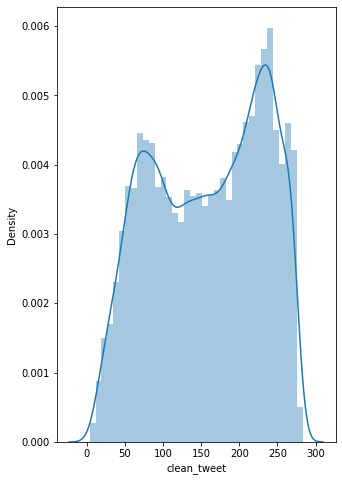

In [109]:
# Plot tweet length distribution
plt.figure(figsize=(5,8))
sns.distplot(df.clean_tweet.str.len())

In [110]:
# Look at shortest tweets. These are mainly aimed directly at people (replies?) or reference other images or tweets.
# They contain nouns (hence passed the exclusion) but don't seem to have a pattern I can easily discern around noun type or determiner. 

df[df['clean_tweet'].str.len() < 42].head()

,clean_tweet,emojis,hashtags_clean,mentions,likes,link_check,time,verified,user,tweets,prep_tweet,noun_check,polarity,subjectivity
21,President at COP26,[],[COP26],"[GreenCongressKE, Martin_Ogindo]",1,True,2021-11-04 10:10:29,False,Harold Mugozi,@GreenCongressKE President @Martin_Ogindo at ...,[president],True,0.0,0.0
179,Its Energy Day at COP26,[],[COP26],[],0,True,2021-11-04 10:06:59,False,Burnham & Weston Energy CIC,It's Energy Day at #COP26. https://t.co/CHLINu...,"[energy, day]",True,0.0,0.0
224,We have liftoff GlasgowDeclaration COP26,[],"[GlasgowDeclaration, COP26]","[1PlanetTourism, UNWTO, VisitScotland, Tourism...",27,True,2021-11-04 10:05:35,False,Travel Foundation,We have lift-off! #GlasgowDeclaration #COP26 @...,"[liftoff, glasgowdeclaration]",True,0.0,0.0
229,COP26 Do as I say not as I do,[],[COP26],[],2,False,2021-11-04 10:05:28,False,chris collings 💚⚓️💙🏴󠁧󠁢󠁷󠁬󠁳󠁿🇬🇧,"#COP26 Do as I say, not as I do.",[],True,0.0,0.0
232,And back at the COP26,[],[COP26],[],1,True,2021-11-04 10:05:23,False,Oceane,And back at the #COP26 https://t.co/Zwfpw9eGeK,[],True,0.0,0.0


In [111]:
# Remove tweets that are too short and unrepresentative of our overall data from our graph
df = df[df['clean_tweet'].str.len() > 42]

#### GDSMM Model Application / Load
Note the model takes a while to run 30-60 mins fresh so the model is saved to a folder called 'models' when run.

In [112]:
# Define the vocab set for our tweets
vocab = set(word for sentence in df.prep_tweet for word in sentence)
n_terms = len(vocab)

In [113]:
# # Fit GSDMM model
# mgp = MovieGroupProcess(K = 30, alpha = 0.09, beta = 0.11, n_iters = 40)
# y = mgp.fit(df.prep_tweet, n_terms)

In [114]:
# # Save GSDMM model
# with open(r'models/v2.model', 'wb') as f:
#  pickle.dump(mgp, f)
#  f.close()

In [115]:
# Load saved model
mgp = pickle.load(open(r'models/v2.model', 'rb'))

In [116]:
# Function to show the most used words in each of our categories 
def top_words(mgp, top_clusters, num_words):
    for cluster in top_clusters:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(), key = lambda k: k[1], reverse = True)[:num_words]
        print ('-'*30)
        print('Cluster {}: {}'.format(cluster, sort_dicts))

In [117]:
# Output the clusters information in a readable format
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic: {}'.format(np.sort(doc_count)[::-1]))
print('Number of documents per topic :', np.sort(doc_count)[::-1])
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)
# Show the top 10 words in term frequency for each cluster 
top_words(mgp, top_index, 10)

Number of documents per topic: [8334 5511 4127 3649 2880 2703 2456 2159 1989 1211  269   71   64   51
   46   35   33   30   29   22   21   20   17   17   16   13   10   10
    3    2]
Number of documents per topic : [8334 5511 4127 3649 2880 2703 2456 2159 1989 1211  269   71   64   51
   46   35   33   30   29   22   21   20   17   17   16   13   10   10
    3    2]
********************
Most important clusters (by number of docs inside): [ 9 28 18 22 23  5 24  6 14 15 26  1 10 13  3]
********************
------------------------------
Cluster 9: [('not', 2158), ('people', 1181), ('climate', 940), ('like', 775), ('think', 695), ('world', 693), ('need', 687), ('change', 681), ('know', 562), ('go', 546)]
------------------------------
Cluster 28: [('climate', 1752), ('country', 1036), ('coal', 892), ('fossil', 758), ('fuel', 718), ('glasgow', 643), ('agreement', 608), ('deal', 599), ('world', 598), ('draft', 585)]
------------------------------
Cluster 18: [('climate', 1166), ('need', 5

We can see extreme cut off after 10 clusters, lets look at them in more detail.

In [118]:
# Define major clusters, so that any other clusters are joined together
clusters = top_index[0:10]

In [119]:
# Assign the model classifcations to our data
def label_cluster(doc_tokens):
    cluster = mgp.choose_best_label(doc_tokens)[0]
    if cluster not in clusters:
        cluster = 99
    return cluster

def label_prob(doc_tokens):
    probability = mgp.choose_best_label(doc_tokens)[1]
    return probability

df['cluster'] = df.prep_tweet.apply(lambda x: label_cluster(x))
df['probability'] = df.prep_tweet.apply(lambda x: label_prob(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.6, 1.0)

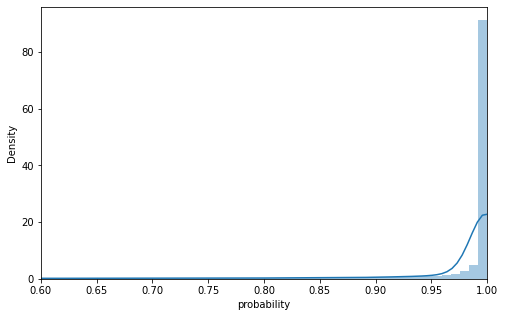

In [122]:
# Plot cluster probabilities 
plt.figure(figsize=(8,5))
sns.distplot(df.probability, bins = 100)
plt.xlim(0.6,1)

The probabilities output by the model are very high (a very small number of entries are left off the graph to the left)

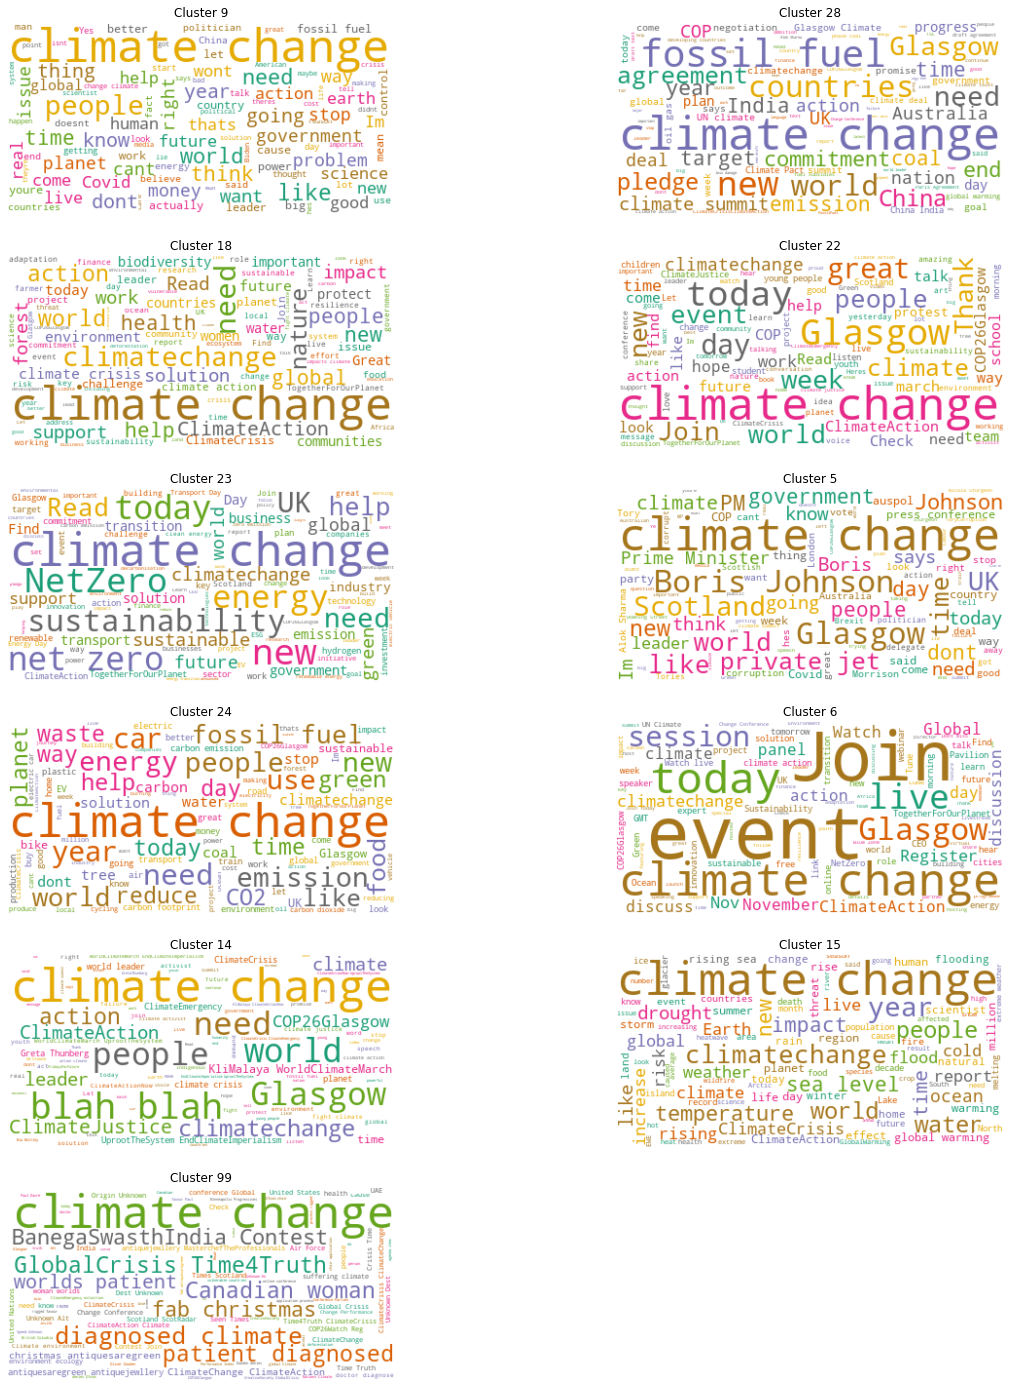

In [124]:
clusters = np.append(clusters, 99)

plt.figure(figsize = (20,25))

wc = WordCloud(stopwords = nlp.Defaults.stop_words, background_color="white", colormap="Dark2", max_words = 100,
               max_font_size=75, collocations = True, random_state=42)

# Create subplots for each cluster
count = 0
for cluster in clusters:
    wc.generate(' '.join(df[df['cluster'] == cluster].clean_tweet))
    plt.subplot(6, 2, count + 1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Cluster ' + str(cluster))
    count +=1
    
plt.show()

Looking at these clusters we can some clear topics have been found within our dataset (99 is an amalgamation of the other categories) - this is my interpretation of each topic so far:
- 9 - General climate change vocabulary
- 28 - Fossil fuels and emissions agreements
- 18 - Call to action for health / nature / planet
- 22 - Event specific (days, timings, glasgow)
- 23 - Net zero 
- 5 - Politics around the event (Glasgow, Boris, private jets etc)
- 24 - Waste / Emissions and calls for alternatives
- 6 - Event specific (days, timings, glasgow
- 14 - Hashtags from COP
- 15 - Effect of Climate Change on Earth (Drought, carbon water etc)
- 99 - No clear topic - need to investigate the diagnosed bigrams




## 2. Overall Sentiment

Text(0, 0.5, '<-- Facts -------- Opinions -->')

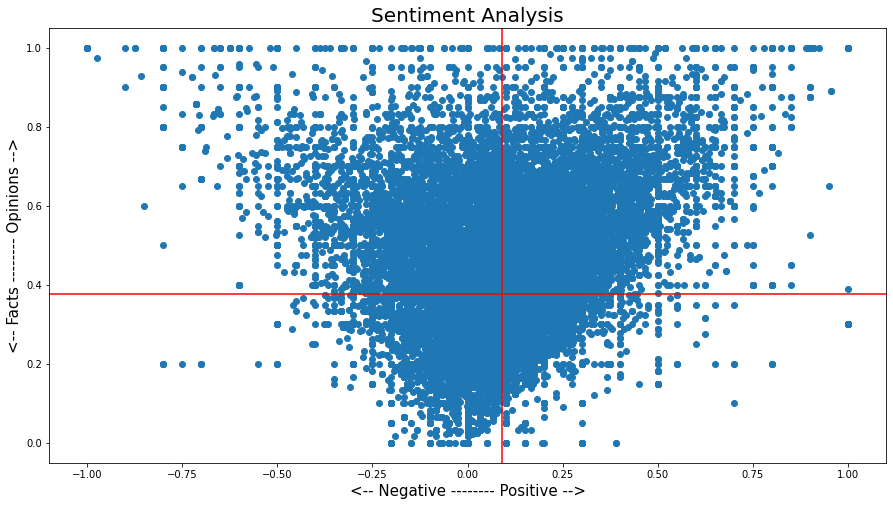

In [125]:
# Plot the sentiment scores of all of our tweets.
# Can clearly see a triangular shape, which showing that the more factual a tweet is, the more likely it is to be neutral
plt.figure(figsize = (15,8))
plt.scatter(df['polarity'], df['subjectivity'])
plt.axhline(y = df['subjectivity'].mean(), color='r', linestyle='-')
plt.axvline(x = df['polarity'].mean(), color='r', linestyle='-')
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

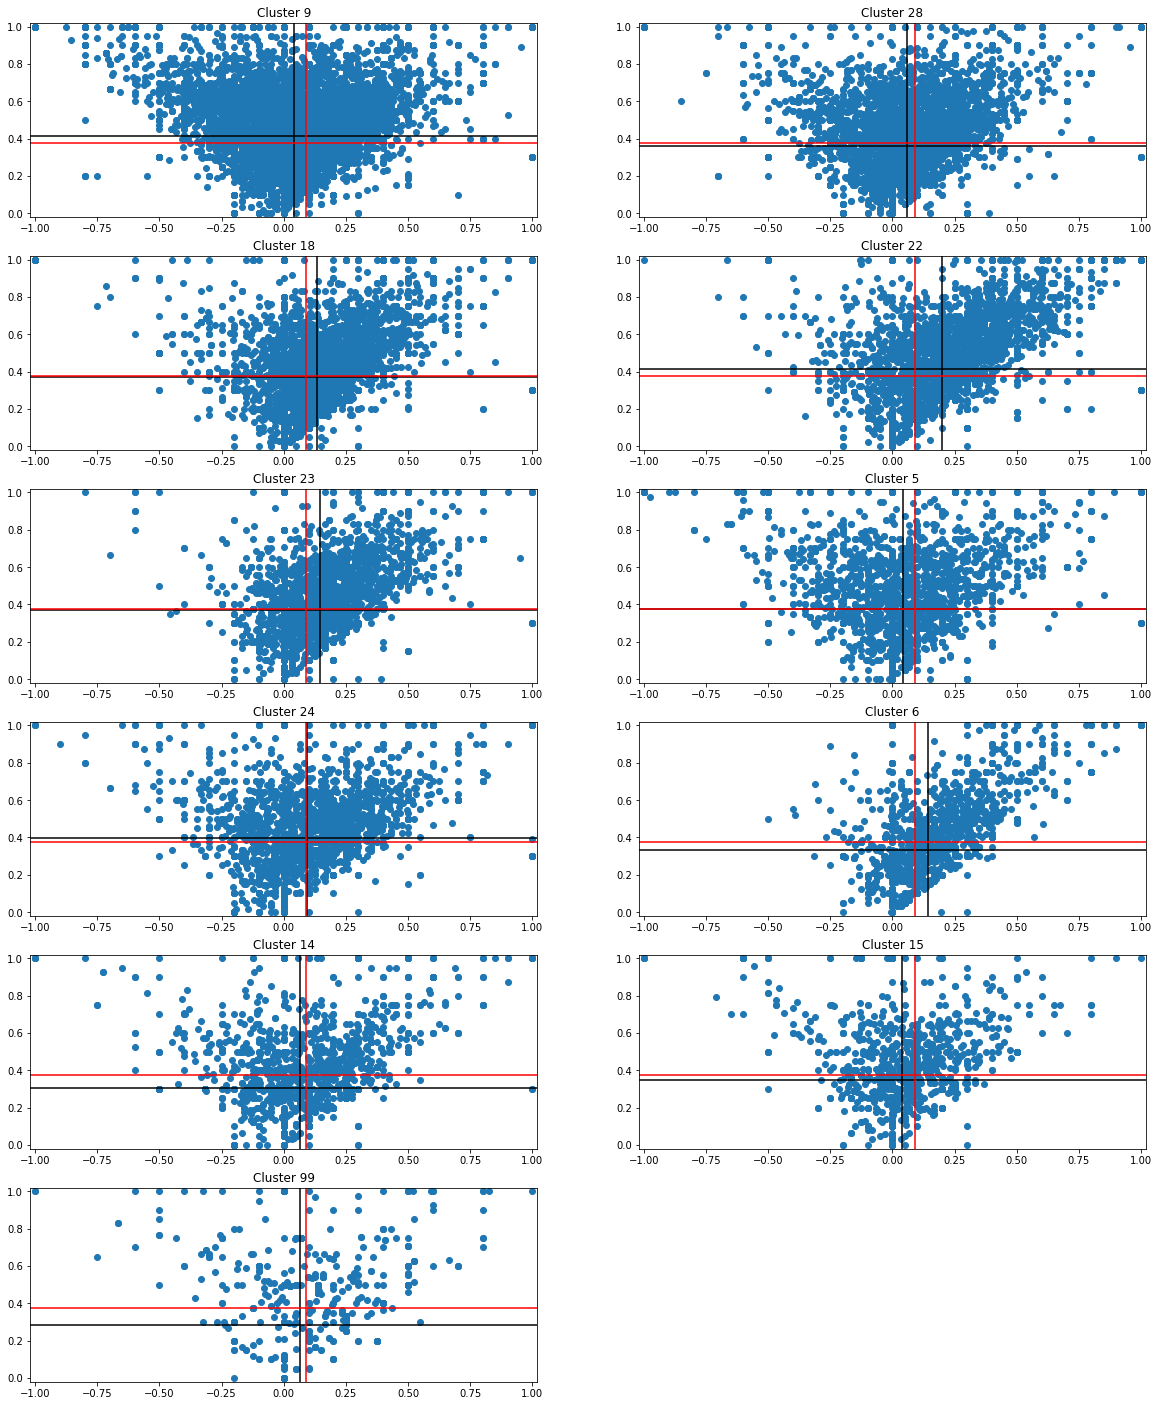

In [134]:
plt.figure(figsize = (20,25))
# Create subplots for each cluster - Red is the original sentiment on the dataset and black is the sentiment for that specific cluster
count = 0
for cluster in clusters:
    temp_df = df[df['cluster'] == cluster]
    plt.subplot(6, 2, count + 1)
    plt.scatter(temp_df['polarity'], temp_df['subjectivity'])
    plt.title('Cluster ' + str(cluster))
    plt.ylim(-0.02,1.02)
    plt.xlim(-1.02,1.02)
    plt.axhline(y = temp_df['subjectivity'].mean(), color='k', linestyle='-')
    plt.axvline(x = temp_df['polarity'].mean(), color='k', linestyle='-')
    plt.axhline(y = df['subjectivity'].mean(), color='r', linestyle='-')
    plt.axvline(x = df['polarity'].mean(), color='r', linestyle='-')
    count += 1
plt.show()

We can see in these graphs the sentiment for each individual cluster. The red axis show the average sentiment over the entire dataset while the black axis show the sentiment for the specific cluster displayed. There seems to be more variance in sentiment than in subjectivity for the clusters.

Interesting call outs are: 
- For all clusters with a positively shifted polarity, we lose the classic V shape we had in our original graph, and we see the positive half of our graph (/). However we don't see the reverse for the charts with a negatively shifted polarity.
- The larges positive shifts were seen in the event specific tweet clusters, along with call the action clusters about planetary health and net zero (note these are more focused in the future).
- Negative polatiry shifts were seen for the fossil fuel and effects of climate change clusters (along with the political cluster).


In [127]:
# Add emoji descriptions back into the clean tweets for sentiment analysis
df['temp_emojis'] = [' '.join(map(str, item)) for item in df['emojis']]
df['temp_clean_tweet'] = df['clean_tweet'] + ' ' + df['temp_emojis']

In [128]:
# Run a second sentiment analysis using vader, which has been designed for use on social media data
# GitHub here: https://github.com/cjhutto/vaderSentiment
df['vs_polarity'] = df.temp_clean_tweet.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])

In [129]:
# Check min and max of polarity
print(df.vs_polarity.max())
print(df.vs_polarity.min())

0.9945
-0.9886


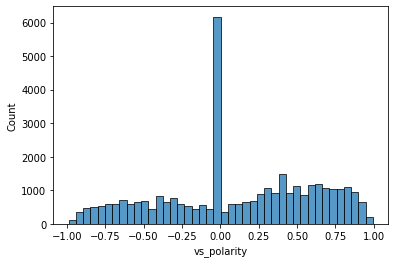

In [130]:
# Overall plot os polarity
sns.histplot(data = df, x = 'vs_polarity')

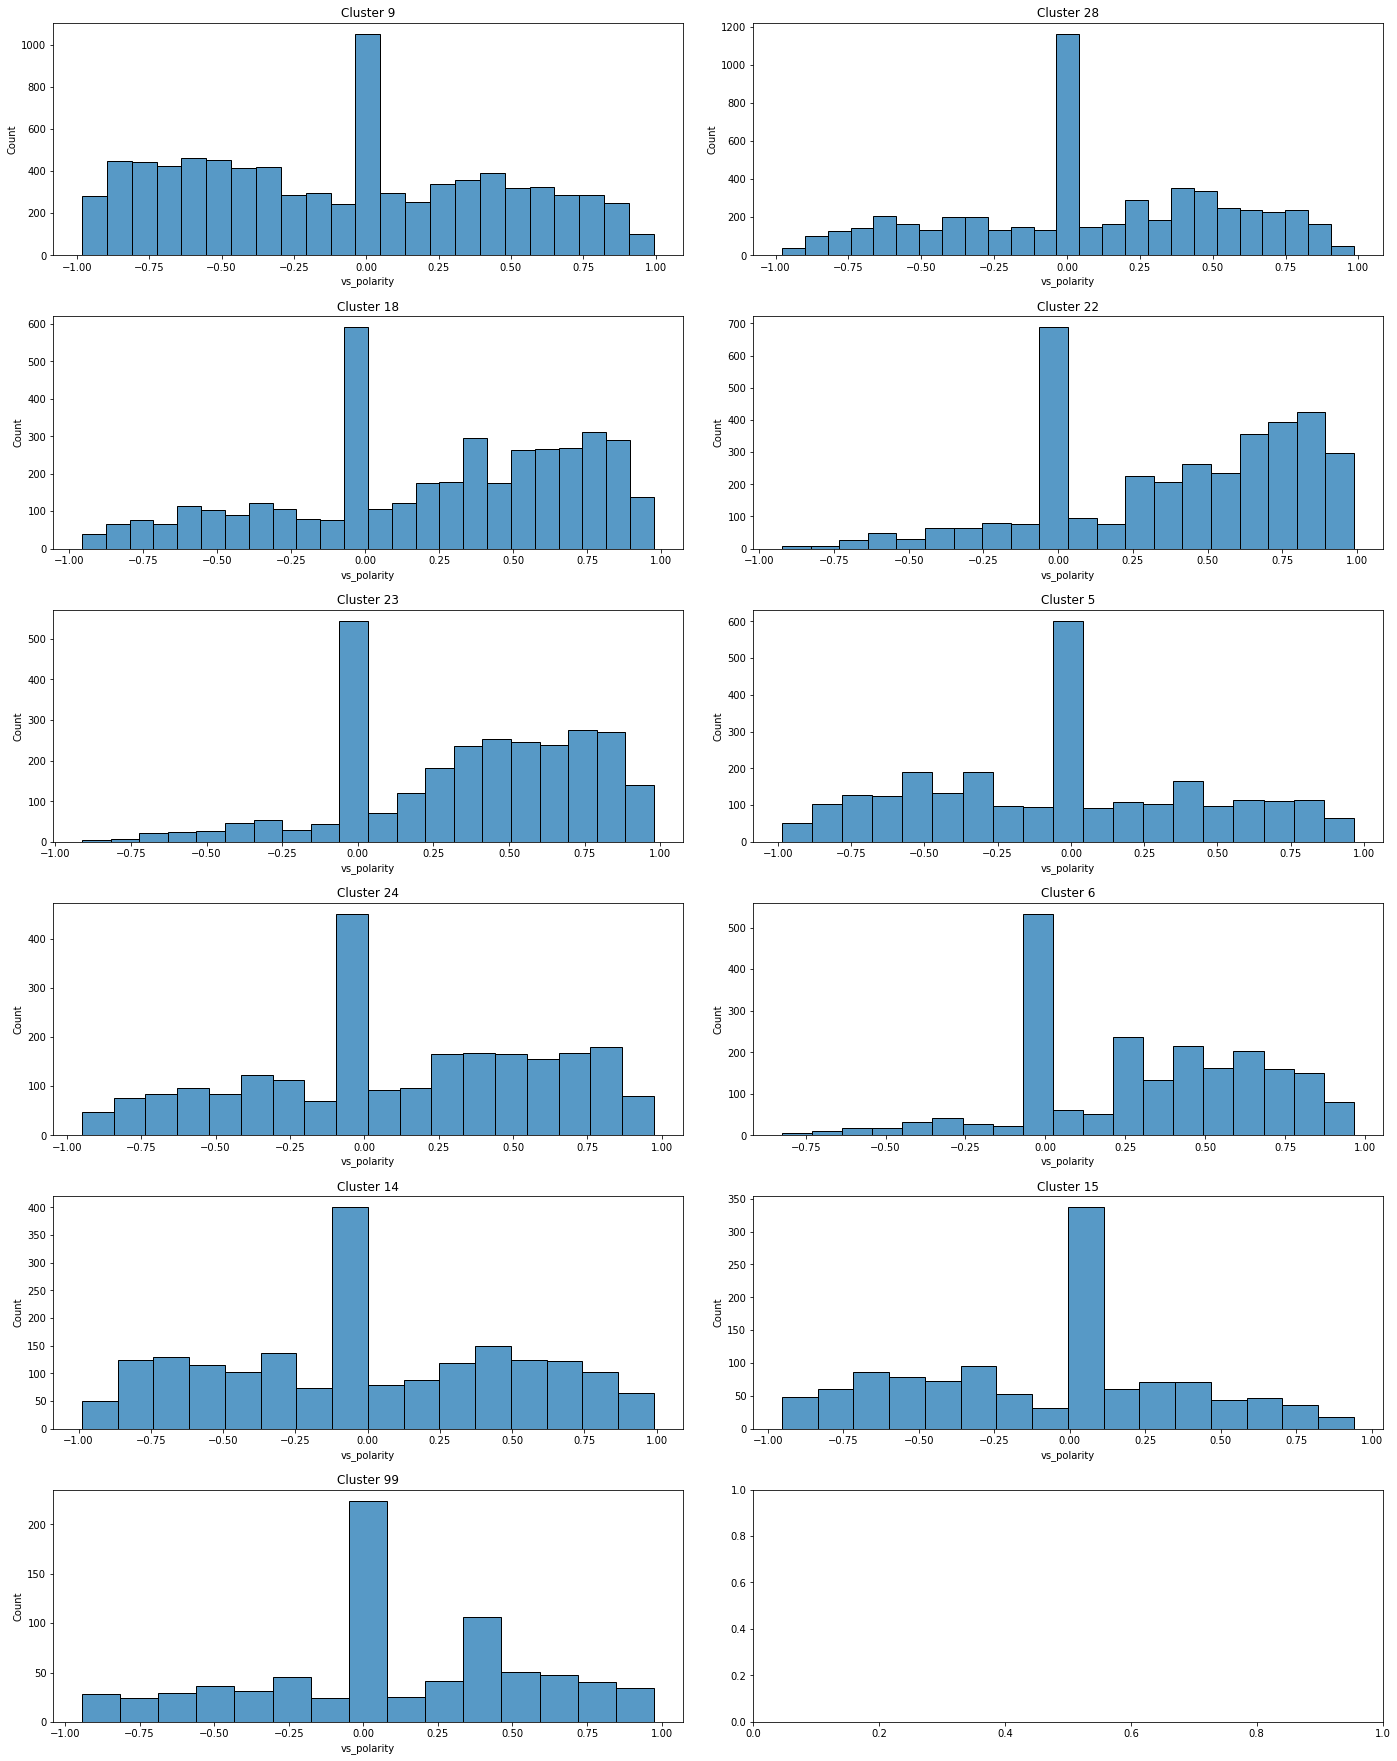

In [135]:
# Create the hist plots for sentiment over each cluster
fig, axes = plt.subplots(6,2, figsize=(20,25))
fig.tight_layout(pad = 4)
count = 0
for name, ax in zip(clusters, axes.flatten()):
    temp_df = df[df['cluster'] == name]
    ax.set_title('Cluster ' + str(name))
    sns.histplot(data = temp_df, x = 'vs_polarity', ax=ax)
    count += 1

These charts give us similar overall sentiment distributions to the previous charts using .

The largest negative shift is: -1.7993999999999999
The 5% percentile: -0.7732
The mean shift: 0.0028555555555555695
The 95th percentile: 0.7022666666666666
The largets postive shift is: 1.8271


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


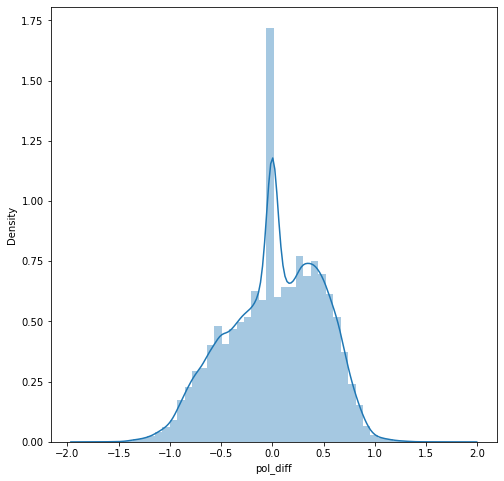

In [132]:
# Polarity differences between the two polarity methods
df['pol_diff'] = df['vs_polarity'] - df['polarity']

# Look at tweet lengths - note these include the stop words, so length is overstated for modelling purposes
print('The largest negative shift is:', df['pol_diff'].min())
print('The 5% percentile:', df['pol_diff'].quantile(q=0.05))
print('The mean shift:', df['pol_diff'].quantile(q=0.5))
print('The 95th percentile:', df['pol_diff'].quantile(q=0.95))
print('The largets postive shift is:', df['pol_diff'].max())

# Plot tweet length distribution
plt.figure(figsize=(8,8))
sns.distplot(df.pol_diff)
